https://www.tensorflow.org/tutorials/structured_data/time_series

In [178]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [179]:
from load_powerball_xls import load_xlsx
df = load_xlsx('2020-04-01_draw_results')

11


In [180]:
df.tail(4)

,Draw,Date,1,2,3,4,5,6,Bonus,Bonus 2nd,Powerball
1943,1944,2020-03-21,9,18,16,20,28,19,7,NaN,5.0
1944,1945,2020-03-25,17,8,27,7,10,21,29,NaN,7.0
1945,1946,2020-03-28,3,2,39,19,35,37,23,NaN,10.0
1946,1947,2020-04-01,8,21,25,28,32,35,18,0.0,3.0


In [181]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [182]:
tf.random.set_seed(13)

## Ball to Predict

In [183]:
Ball_to_predict = '1'
# Ball_to_predict = '2'
# Ball_to_predict = '3'
# Ball_to_predict = '4'
# Ball_to_predict = '5'
# Ball_to_predict = '6'
# Ball_to_predict = 'Bonus'
#Ball_to_predict = 'Bonus 2nd'
#Ball_to_predict = 'Powerball'

In [184]:
dft = df.dropna(subset=[Ball_to_predict])

uni_data = dft[Ball_to_predict]
uni_data.index = dft.index

In [185]:
uni_data = dft[Ball_to_predict]
uni_data.index = dft['Draw']
uni_data.head()

Draw
1     4
2     3
3    11
4    35
5    23
Name: 1, dtype: int64

In [186]:
TRAIN_SPLIT = len(dft.index*.8)
#TRAIN_SPLIT = int(dft['Draw'].loc[df['Draw'].idxmax()]*.8)
TRAIN_SPLIT

1947

In [187]:
# uni_data.plot(subplots=True)

In [188]:
uni_data = uni_data.values

In [189]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_mean

18.67899332306112

In [190]:
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_train_std

12.09792205045295

In [191]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [192]:
uni_data

array([-1.21334831, -1.29600714, -0.63473655, ..., -0.13878361,
       -1.29600714, -0.88271302])

In [193]:
univariate_past_history = 8
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [194]:
print ('Single window of past history')
print (x_train_uni[-1])
print ('\n Bonus ball to predict')
print (y_train_uni[-1])

Single window of past history
[[ 0.93578109]
 [ 0.6051458 ]
 [ 0.2745105 ]
 [ 1.43173403]
 [ 1.43173403]
 [-0.8000542 ]
 [-0.13878361]
 [-1.29600714]]

 Bonus ball to predict
-0.8827130211722017


In [195]:
print ('Single window of past history')
print (x_train_uni[-1]*uni_train_std+uni_train_mean)
print ('\n Bonus ball to predict')
print (y_train_uni[-1]*uni_train_std+uni_train_mean)

Single window of past history
[[30.]
 [26.]
 [22.]
 [36.]
 [36.]
 [ 9.]
 [17.]
 [ 3.]]

 Bonus ball to predict
8.0


In [196]:
def create_time_steps(length):
  return list(range(-length, 0))

In [197]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Users/ricmagno/.virtualenvs/Lotto/lib/python3.7/site-packages/matplotlib/pyplot.py'>

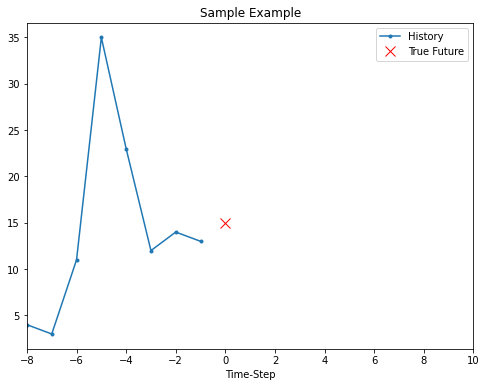

In [198]:
show_plot([x_train_uni[0]*uni_train_std+uni_train_mean, 
           y_train_uni[0]*uni_train_std+uni_train_mean], 
          0, 'Sample Example')

In [199]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/ricmagno/.virtualenvs/Lotto/lib/python3.7/site-packages/matplotlib/pyplot.py'>

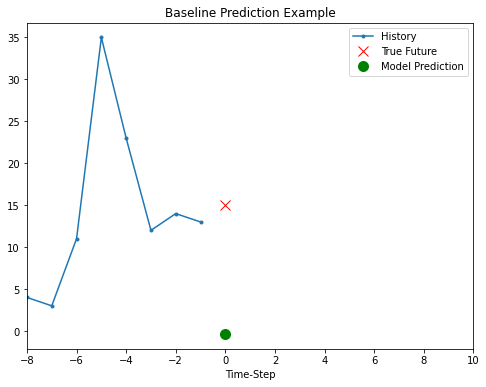

In [200]:
show_plot([x_train_uni[0]*uni_train_std+uni_train_mean, 
           y_train_uni[0]*uni_train_std+uni_train_mean, 
           baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [201]:
BATCH_SIZE = 256
BUFFER_SIZE = 300

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [202]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [203]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

In [204]:
train_univariate

<RepeatDataset shapes: ((None, 8, 1), (None,)), types: (tf.float64, tf.float64)>

In [205]:
EVALUATION_INTERVAL = 300
EPOCHS = 100

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

ValueError: in converted code:

    /Users/ricmagno/.virtualenvs/Lotto/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /Users/ricmagno/.virtualenvs/Lotto/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /Users/ricmagno/.virtualenvs/Lotto/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected lstm_5_input to have 3 dimensions, but got array with shape (None, 1)


In [361]:
score = simple_lstm_model.evaluate(x_val_uni, y_val_uni, verbose=1)
score

382/382 [==============================] - 0s 75us/sample - loss: 0.8632


0.8632275162567019

In [362]:
ver = '002'
simple_lstm_model.save('./Models/' + Ball_to_predict + ver)

INFO:tensorflow:Assets written to: ./Models/6002/assets


# Predict

In [234]:
last_result = np.reshape(
    np.array(df[Ball_to_predict].tail(8)),
    (8,1))
last_result.shape

(8, 1)

In [235]:
last_result

array([[39],
       [39],
       [29],
       [25],
       [12],
       [18],
       [ 8],
       [ 2]])

In [236]:
last_result = ((last_result-uni_train_mean)/uni_train_std)
last_result

array([[ 1.73985343],
       [ 1.73985343],
       [ 0.85785306],
       [ 0.50505291],
       [-0.64154757],
       [-0.11234735],
       [-0.99434772],
       [-1.52354794]])

In [359]:
last_result = tf.convert_to_tensor(
    [last_result,last_result], dtype=np.float64, dtype_hint=None, name=None
)
last_bonus

<tf.Tensor: shape=(2, 8, 1), dtype=float64, numpy=
array([[[ 0.96054498],
        [ 0.63383686],
        [ 0.30712873],
        [ 1.45060716],
        [ 1.45060716],
        [-0.75467267],
        [-0.10125642],
        [-1.24473485]],

       [[ 0.96054498],
        [ 0.63383686],
        [ 0.30712873],
        [ 1.45060716],
        [ 1.45060716],
        [-0.75467267],
        [-0.10125642],
        [-1.24473485]]])>

In [238]:
# simple_lstm_model.predict(x[:1])

# Predict current draw

In [358]:
simple_lstm_model.predict(last_result[:1])*uni_train_std+uni_train_mean

array([[13.684827]], dtype=float32)

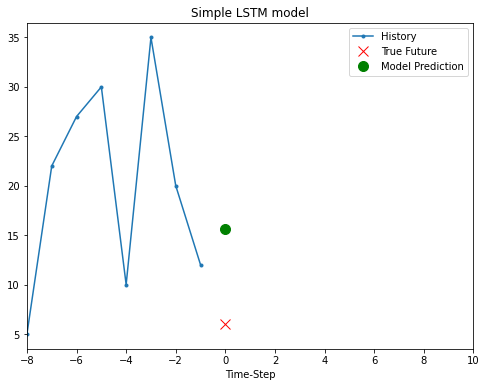

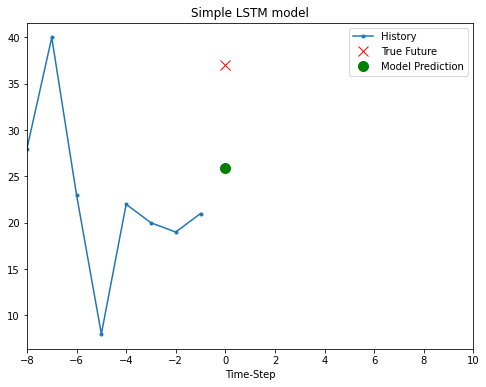

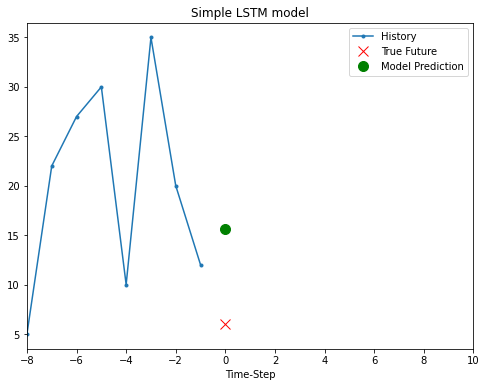

In [360]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[-1].numpy()*uni_train_std+uni_train_mean, y[-1].numpy()*uni_train_std+uni_train_mean,
                    simple_lstm_model.predict(x)[-1]*uni_train_std+uni_train_mean], 0, 'Simple LSTM model')
  plot.show()